<a href="https://colab.research.google.com/github/bsussel3/2023-s1-ci/blob/main/aula_05_arvore_decisao_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 05: Árvore de decisão

Mais uma vez, vamos abordar o problema de detecção de diabetes a partir de um conjunto de atributos pessoais (como idade) e medidas relacionadas ao organismo da pessoa (como a pressão sanguínea).

*Dataset*: https://www.kaggle.com/datasets/mathchi/diabetes-data-set/data


In [2]:
""" Importando os pacotes necessários """

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.impute import SimpleImputer


## 1) Baixando o *dataset* do Github

In [3]:
""" Carregando o dataset do Github para trabalhar autonomamente no Colab """

import requests
from pathlib import Path

# Caminho para a pasta que conterá o dataset
data_path = Path("data/")

# Se o diretório ainda não existe, criamos e baixamos o dataset
if data_path.is_dir():
    print(f"O diretório {data_path} já existe")
else:
    print(f"Diretório {data_path} não localizado, criando um ...")
    data_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "diabetes.csv", "wb") as f:
        request = requests.get("https://github.com/EA991-Lab/utils/raw/main/data/diabetes.csv")
        print("Baixando os dados ...")
        f.write(request.content)

Diretório data não localizado, criando um ...
Baixando os dados ...


## 2) Análise inicial do *dataset*

In [4]:
""" Carregamos o dataset e analisamos algumas de suas características """

#leitura do arquivo completo de dados
data = pd.read_csv(data_path / "diabetes.csv")

#dicionário para mapear as classes nos números desejados
labels = {0: 'Normal', 1: 'Diabetes'}

#acrescenta a coluna 'labels' mapeando os valores de 'Outcome' conforme o dicionário criado
data['labels'] = data['Outcome'].map(labels)

#nomes das classes
class_names = ['Normal','Diabetes']

#visualização de parte inicial do dataset
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,labels
0,6,148,72,35,0,33.6,0.627,50,1,Diabetes
1,1,85,66,29,0,26.6,0.351,31,0,Normal
2,8,183,64,0,0,23.3,0.672,32,1,Diabetes
3,1,89,66,23,94,28.1,0.167,21,0,Normal
4,0,137,40,35,168,43.1,2.288,33,1,Diabetes


### 2.1 Pré-processamento: valores faltantes

É possível notar a aparição de valores nulos indevidos para alguns atributos, como 'BloodPressure'. Nestes casos, vamos substituir por `NaN` para, depois, usar uma técnica de imputação.

In [5]:
#colunas com atributos faltantes
missing_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
#substituímos os 0s por NaN
data[missing_columns] = data[missing_columns].replace(to_replace=0.0, value=np.nan)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,labels
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1,Diabetes
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0,Normal
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1,Diabetes
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Normal
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Diabetes


## 3) Preparação do conjunto de dados

Passos:
- Divisão em treinamento e teste;
- Imputação e normalização.


In [6]:
#extrai os atributos de entrada do DataFrame
X = data.iloc[:,:-2]
#extrai do DataFrame os rótulos numéricos
y = data["Outcome"]

#opção: stratify = y - separa as amostras mantendo a proporção que os labels originalmente têm (no caso, 1/3, 1/3 e 1/3)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

""" Imputação e normalização dos atributos """
imputer = SimpleImputer()
scaler = StandardScaler()

#faz a imputação dos valores nas partições de treinamento e teste
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

#em seguida, aplica a normalização
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#separa do conjunto de treinamento original uma parcela para servir como validação
X_train_part, X_val_scaled, y_train_part, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=1,stratify=y_train)

print(f"Dimensões das partições de dados\n")
print(f"Conjunto de treinamento: {X_train_part.shape}")
print(f"Conjunto de validação: {X_val_scaled.shape}")
print(f"Conjunto de teste: {X_test.shape}")

Dimensões das partições de dados

Conjunto de treinamento: (491, 8)
Conjunto de validação: (123, 8)
Conjunto de teste: (154, 8)


## 4) Árvore de decisão

### 4.1 Busca em grade

In [11]:
k = 5
f = (k - 1) / k

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={
        "criterion": ["gini", "entropy"],
        "max_depth": np.arange(1, 5),
        "min_samples_split": np.linspace(0.0016, 0.008, 5),
        "min_samples_leaf": np.linspace(0.0016, 0.008, 5),
        "random_state": [0],
        "min_impurity_decrease": np.linspace(0, 1, 6),
        "ccp_alpha": np.linspace(0, 1, 6),
    },
    cv=k,
)

grid.fit(X_test_scaled, y_test)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([1, 2, 3, 4]),
                         'min_impurity_decrease': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
                         'min_samples_leaf': array([0.0016, 0.0032, 0.0048, 0.0064, 0.008 ]),
                         'min_samples_split': array([0.0016, 0.0032, 0.0048, 0.0064, 0.008 ]),
                         'random_state': [0]})

### 4.2 Aplicação da melhor árvore ao conjunto de teste e análise do desempenho

In [15]:
y_pred = grid.predict(X_train_scaled)



### 4.3 Visualização da estrutura da melhor árvore

In [14]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

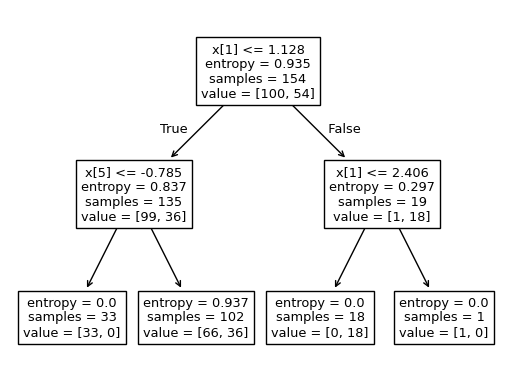

In [13]:
from sklearn.tree import plot_tree

#nomes dos atributos
feature_names = X.columns.tolist()

plot_tree(grid.best_estimator_)

plt.show()

### Para pensar: É preciso mesmo fazer imputação nos casos de valores faltantes? E normalização?

Experimentem remover estas etapas e analisem os resultados (e a estrutura da árvore obtida).